# 1. Introduction: The US Opioid Epidemic

In 2017 the United States reached a [record high](https://www.nytimes.com/interactive/2018/11/29/upshot/fentanyl-drug-overdose-deaths.html) of 70,237 drug overdose deaths, according to recent data from the [Department of Health and Human Services](www.cdc.gov/drugoverdose/epidemic/index.html). This represents a [9.6% increase](https://www.cdc.gov/drugoverdose/data/statedeaths.html) in age-adjusted deaths in just one year. About 68% of these deaths are opioid-related. 

In response to the severity of the crisis, in October 2018 the US Congress passed a [landmark bill](https://www.usatoday.com/story/news/politics/2018/10/24/donald-trump-opioids-bill-includes-changes-trafficking-treatment/1752329002/) to address the problem on several fronts. Among the approaches is to expand the use of ‘comprehensive recovery centers’ that provide an array of services to recovering addicts. Making the best use of these new funds, as well as state and local resources, can be aided by the ability to predict which locations around the US will have the greatest demand for these services. It may also be helpful to understand and what local socioeconomic characteristics, if any, are most associated with high levels of drug overdose deaths. Addressing these two needs is the focus of this report.


# 1.1 Measuring the Opioid Crisis
To investigate these questions two types of data are needed: 1) data on the extent of the opioid crisis in different parts of the US, and 2) socioeconomic data for those same regions.

The overdose mortality rate is just one possible measure of the opioid crisis. It would be preferable to use a broader indicator, such as addiction prevalence, so as to focus on more common and earlier stages of the problem. Mortality data has the advantage of being collected consistently across the country, which is a key requirement.  The primary source for mortality data in the US is the  [CDC WONDER](https://wonder.cdc.gov/) system, which is an interactive site that creates data extracts on the fly. (There is currently no API for this interactive system.) Data can be broken down by cause of death, population, year, and geographic unit. 

The limitation to CDC WONDER mortality data, however, is that small numbers of deaths (<10) are suppressed by the system, resulting in missing data. For annual data from geographic areas smaller than the state level, the result is an unacceptable amount of missing data.

Another option is to use a [smoothed mortality rate data set](https://data.cdc.gov/NCHS/NCHS-Drug-Poisoning-Mortality-by-County-United-Sta/pbkm-d27e) available from the National Center for Health Statistics (NCHS) that provides annual county-level age-adjusted drug poisoning rates in fairly narrow bins. The rate is measured in deaths per 100,000 and then binned by 2's: i.e., <2, 2-3.9, 4-5.9, up to 30+. The  midpoints of the ranges can be used to approximate a continuous variable. Data is available for all US counties for the period 1999-2016.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata

In [2]:
# Read in "NCHS - Drug Poisoning Mortality by County" from CDC using Socrata API

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# First 100000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("n4bg-95bt", limit=100000)

# Convert to pandas DataFrame
NCHS_raw = pd.DataFrame.from_records(results)

In [3]:
NCHS_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56448 entries, 0 to 56447
Data columns (total 7 columns):
county                                                       56448 non-null object
estimated_age_adjusted_death_rate_16_categories_in_ranges    56448 non-null object
fips                                                         56448 non-null object
fips_state                                                   56448 non-null object
population                                                   56448 non-null object
state                                                        56448 non-null object
year                                                         56448 non-null object
dtypes: object(7)
memory usage: 3.0+ MB


In [4]:
# Read in "NCHS - Drug Poisoning Mortality by County" - no need to keep downloading file
# NCHS_raw = pd.read_csv('./cdc/NCHS_-_Drug_Poisoning_Mortality_by_County__United_States.csv')

In [5]:
# Recode categories to continuous

def recode(x): 
    """Recode string mortality categories to point estimates"""
    if x == "<2": 
        return 1
    elif x == "2-3.9": 
        return  3
    elif x == "4-5.9": 
        return  5
    elif x == "6-7.9": 
        return  7
    elif x == "8-9.9": 
        return  9
    elif x == "10-11.9": 
        return  11
    elif x == "12-13.9": 
        return  13
    elif x == "14-15.9": 
        return  15
    elif x == "16-17.9": 
        return  17
    elif x == "18-19.9": 
        return  19
    elif x == "20-21.9": 
        return  21
    elif x == "22-23.9": 
        return  23
    elif x == "24-25.9": 
        return  25
    elif x == "26-27.9": 
        return  27
    elif x == "28-29.9": 
        return  29
    elif x == "30+": 
        return  33

NCHS_raw = NCHS_raw.rename(columns = {'estimated_age_adjusted_death_rate_16_categories_in_ranges':'drug_mort_cat', 
                                      'year':'Year',
                                     'state':'State',
                                     'fips':'FIPS'})    
NCHS_raw['Year'] = NCHS_raw['Year'].astype(int)
NCHS_raw['population'] = NCHS_raw['population'].astype(int)
NCHS_raw['drug_mort'] = NCHS_raw['drug_mort_cat'].apply(recode)   
 

#NCHS_raw.describe()
#NCHS_raw.head()

In [6]:
#NCHS_raw.info()
# Save for later use
# NCHS_raw.to_csv('./data/NCHS_raw.csv')

In [7]:
# Take a quick look at national trends
drug_mort_us = pd.DataFrame(NCHS_raw.groupby('Year')['drug_mort'].mean())
drug_mort_us['Year'] = pd.to_datetime(drug_mort_us.index, format = '%Y')

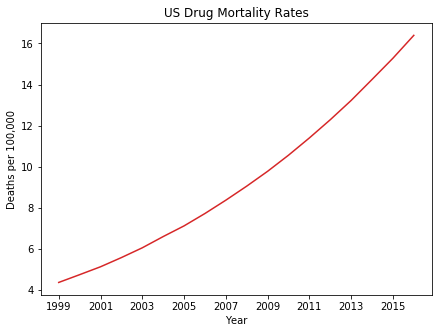

In [8]:
# Plot US drug mortality rates over time
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)

plt.title('US Drug Mortality Rates') 
plt.plot(drug_mort_us['Year'], drug_mort_us['drug_mort'], color = 'tab:red')

ax.set_xlabel('Year')
ax.set_ylabel('Deaths per 100,000')

plt.show()

#### These trend lines show how quickly drug-related deaths have increased from 1999-2016. It is important to note that the NCHS data is not broken down by type of drug involved. Other sources, such as this report from the [National Institute on Drug Abuse](https://www.drugabuse.gov/related-topics/trends-statistics/overdose-death-rates), indicate the rise in deaths is primarily due to opioid related drugs (including heroin, natural opioids, methadone, fentanyl, and other synthetic opioids). Disturbingly, the NIDA report provides national estimates for the years 2016-17 that show continued acceleration of opioid deaths. In particular, deaths attributed to fentanyl rose from near 10,000 in 2015 to over 29,000  in 2017.




In [9]:
#Calculate mean and std dev of mortality in 1999, 2008, and 2016
drug_mort_1999 = NCHS_raw[NCHS_raw.Year == 1999]
drug_mort_2008 = NCHS_raw[NCHS_raw.Year == 2008]
drug_mort_2016 = NCHS_raw[NCHS_raw.Year == 2016]

# save for later use
#drug_mort_2016.to_csv('./data/drug_mort_2016.csv')

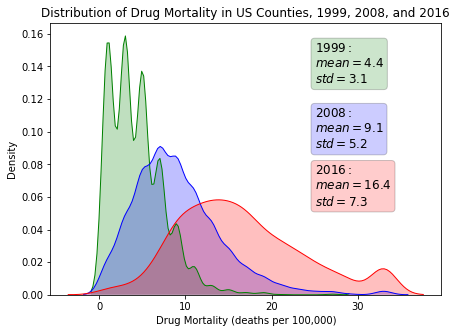

In [10]:
#Summaries
mean_1999 = np.mean(drug_mort_1999.drug_mort)
std_1999  = np.std(drug_mort_1999.drug_mort)
mean_2008 = np.mean(drug_mort_2008.drug_mort)
std_2008  = np.std(drug_mort_2008.drug_mort)
mean_2016 = np.mean(drug_mort_2016.drug_mort)
std_2016  = np.std(drug_mort_2016.drug_mort)

fig, ax = plt.subplots()

textstr_1999 = '$1999:$\n$mean=%.1f$\n$std=%.1f$' % (mean_1999, std_1999)
textstr_2008 = '$2008:$\n$mean=%.1f$\n$std=%.1f$' % (mean_2008, std_2008)
textstr_2016 = '$2016:$\n$mean=%.1f$\n$std=%.1f$' % (mean_2016, std_2016)

fig.set_size_inches(7, 5, forward=True)
sns.kdeplot(drug_mort_1999.drug_mort, shade=True, linewidth=1, legend=False, color='g')
sns.kdeplot(drug_mort_2008.drug_mort, shade=True, linewidth=1, legend=False, color='b')
sns.kdeplot(drug_mort_2016.drug_mort, shade=True, linewidth=1, legend=False, color='r')
plt.title('Distribution of Drug Mortality in US Counties, 1999, 2008, and 2016');
ax.set_xlabel("Drug Mortality (deaths per 100,000)")
ax.set_ylabel("Density")

# place a text box in upper left in axes coords
# these are matplotlib.patch.Patch properties
props_1999 = dict(boxstyle='round', facecolor='g', alpha=0.2)
props_2008 = dict(boxstyle='round', facecolor='b', alpha=0.2)
props_2016 = dict(boxstyle='round', facecolor='r', alpha=0.2)
ax.text(25, .13, textstr_1999, fontsize=12, bbox=props_1999)
ax.text(25, .09, textstr_2008, fontsize=12, bbox=props_2008)
ax.text(25, .055, textstr_2016, fontsize=12, bbox=props_2016)
plt.show()

#### The distribution of drug-related deaths has changed form over time and become more normal as deaths have increased. (Note that the tail end of the 2016 distribution is the result of top-coding in the input data). 

In [11]:
# Take a quick look at how different counties are from each other
drug_mort_counties = pd.DataFrame(NCHS_raw.groupby('FIPS')['drug_mort'].\
                                 agg([np.mean, np.median, np.max, np.min]).\
                                 rename(columns ={'mean': 'dm_mean',
                                                 'median': 'dm_median',
                                                 'amax': 'dm_max',
                                                 'amin': 'dm_min'}))
drug_mort_counties['FIPS'] = pd.to_numeric(drug_mort_counties.index)

#drug_mort_counties.head()
# Save for later use
#drug_mort_counties.to_csv('./data/drug_mort_counties.csv')

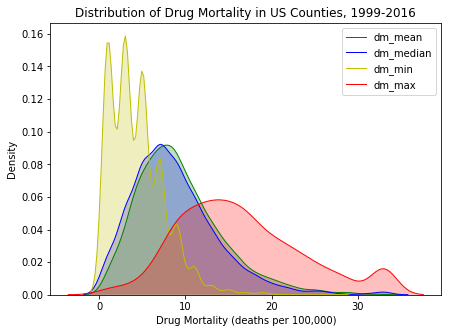

In [12]:
fig, ax = plt.subplots()

fig.set_size_inches(7, 5, forward=True)
sns.kdeplot(drug_mort_counties.dm_mean, shade=True, linewidth=1, legend=False, color='g')
sns.kdeplot(drug_mort_counties.dm_median, shade=True, linewidth=1, legend=False, color='b')
sns.kdeplot(drug_mort_counties.dm_min, shade=True, linewidth=1, legend=False, color='y')
sns.kdeplot(drug_mort_counties.dm_max, shade=True, linewidth=1, legend=False, color='r')
plt.title('Distribution of Drug Mortality in US Counties, 1999-2016')
ax.set_xlabel("Drug Mortality (deaths per 100,000)")
ax.set_ylabel("Density")
plt.legend()

plt.show()


#### The above chart depicts drug mortality aggregated across years for all US counties. We can see that most counties have a minimum drug mortality rate below 10/100,000. Only a minority of counties have a maximum  mortality rate below 10.

In [13]:
# Create column of difference between 2016 mortality and 1999
drug_mort_change_us = drug_mort_2016.merge(drug_mort_1999, on = 'FIPS')
drug_mort_change_us['change'] = drug_mort_change_us.drug_mort_x - drug_mort_change_us.drug_mort_y

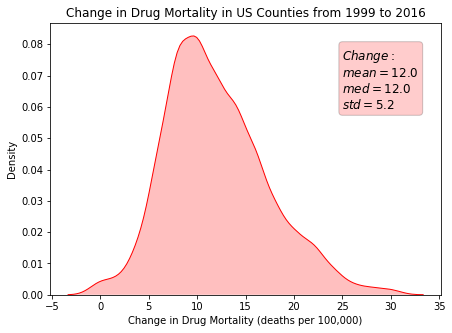

In [14]:
# Calculate change in each county
# Create column of difference between 2016 mortality and 1999
drug_mort_change_us = drug_mort_2016.merge(drug_mort_1999, on = 'FIPS')
drug_mort_change_us['change'] = drug_mort_change_us.drug_mort_x - drug_mort_change_us.drug_mort_y

mean_change = np.mean(drug_mort_change_us.change)
std_change  = np.std(drug_mort_change_us.change)
med_change  = np.median(drug_mort_change_us.change)

fig, ax = plt.subplots()

fig.set_size_inches(7, 5, forward=True)
sns.kdeplot(drug_mort_change_us.change, shade=True, linewidth=1, legend=False, color='r', label='US')
plt.title('Change in Drug Mortality in US Counties from 1999 to 2016')
ax.set_xlabel("Change in Drug Mortality (deaths per 100,000)")
ax.set_ylabel("Density")
#plt.legend()

# place a text box in upper left in axes coords
# these are matplotlib.patch.Patch properties
textstr = '$Change:$\n$mean=%.1f$\n$med=%.1f$\n$std=%.1f$' % (mean_change, med_change, std_change)
stats = dict(boxstyle='round', facecolor='r', alpha=0.2)
ax.text(25, .06, textstr, fontsize=12, bbox=stats)

plt.show()

####  From 1999 - 2016, over half of US counties saw an increase in drug-related mortality of 12 or more  deaths per 100,000 population.

In [15]:
# Set up yearly data for heatmap
heatmap = pd.pivot_table(NCHS_raw[['FIPS', 'Year', 'drug_mort']], index='FIPS', columns='Year', values='drug_mort')
heatmap['dm_mean'] = heatmap.mean(axis=1)
heatmap = heatmap.reset_index()
heatmap.sort_values(by='dm_mean', ascending=False, inplace=True)
heatmap = heatmap.drop(columns=['dm_mean', 'FIPS']).T
heatmap.sort_values(by='Year', ascending=False, inplace=True)

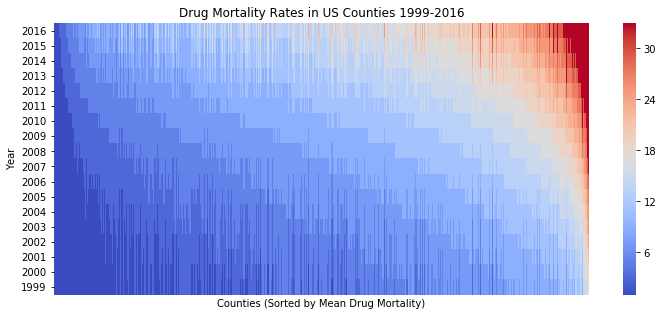

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
#plt.gca().invert_yaxis()
#plt.ylim(1999, 2016) 
plt.title('Drug Mortality Rates in US Counties 1999-2016') 
sns.heatmap(heatmap, xticklabels=False, cmap = 'coolwarm')
ax.set_xlabel('Counties (Sorted by Mean Drug Mortality)')
ax = plt.gca()
#ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

Counties in the heatmap above are sorted left to right by their average drug mortality rate. We can see in this graphic that nearly all US counties saw an increase in drug mortality.